1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix


import itertools

import matplotlib.pyplot as plt

%matplotlib inline

**Работать будем с данными по оттоку клиентов банка:**

In [2]:
df = pd.read_csv('C:/Users/User/Desktop/Машинное обучение в бизнесе/Lection5/churn_data.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


Мы видим что есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить, т.к. это не информативный для нас признак.

Посмотрим на распределение классов (по таргету):

In [3]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

Задача сильно разбалансирована, распределение 1 к 4, это хорошо для банка, но не для нашей последующей работы.

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
# Категориальные признаки закодируем с помощью OneHotEncoding
# Соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        
    def fit(self,X, y=None):
        return self
    
    def transform(self, X):
        scaler = MinMaxScaler()
        X[[self.key]] = scaler.fit_transform(X[[self.key]])
        return X[[self.key]]
        
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
# Посмотрим, что все прошло успешно:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
#Зададим списки признаков:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
#Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться):
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('Min_max', Normalizer(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [8]:
# Проверяем что нормализация вещественных признаков работает
age = Pipeline([
                ('selector', NumberSelector(key='Age')),
                ('Min_max', Normalizer(key='Age'))
            ])
age.fit(X_train)
age.transform(X_test).head(3)

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])


,Age
9394,0.229730
898,0.297297
2398,0.324324


In [9]:
#Объединим все это в единый пайплайн:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [10]:
model = ['XGBClassifier', 'LogisticRegression']
fin_precision = []
fin_recall = []
fin_fscore = []

Добавим модели:

In [11]:
pipeline_xgb = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 12)),
])

In [12]:
#обучим:
pipeline_xgb.fit(X_train, y_train)

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [13]:
#наши прогнозы для тестовой выборки
preds_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
preds_xgb[:10]

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

array([0.337964  , 0.25309741, 0.04990057, 0.02130437, 0.02019478,
       0.8381655 , 0.01507406, 0.09288973, 0.4881824 , 0.8170893 ],
      dtype=float32)

In [14]:
#Посчитаем precision/recall/f_score

precision, recall, thresholds = precision_recall_curve(y_test, preds_xgb)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_xgb = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_xgb], 
                                                                        fscore[ix_xgb],
                                                                        precision[ix_xgb],
                                                                        recall[ix_xgb]))

fin_precision.append(precision[ix_xgb])
fin_recall.append(recall[ix_xgb])
fin_fscore.append(fscore[ix_xgb])

Best Threshold=0.267848, F-Score=0.626, Precision=0.581, Recall=0.680


In [15]:
pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 14)),
])

In [16]:
#обучим:
pipeline_lr.fit(X_train, y_train)

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [17]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[[self.key]] = scaler.fit_transform(X[[self.key]])
C:\Users\User\AppData\Local\Temp\ipykernel_12152\1413777591.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

array([0.21099232, 0.30188108, 0.13449493, 0.11611262, 0.13904548,
       0.56740142, 0.0580026 , 0.07464385, 0.29405525, 0.69581511])

In [18]:
#Посчитаем precision/recall/f_score

precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix_lr = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix_lr], 
                                                                        fscore[ix_lr],
                                                                        precision[ix_lr],
                                                                        recall[ix_lr]))

fin_precision.append(precision[ix_lr])
fin_recall.append(recall[ix_lr])
fin_fscore.append(fscore[ix_lr])

Best Threshold=0.267069, F-Score=0.506, Precision=0.476, Recall=0.540


In [19]:
results = pd.DataFrame(np.column_stack([model, fin_precision, fin_recall, fin_fscore]), 
                               columns=['model', 'precision', 'recall', 'fscore'])

In [20]:
results

,model,precision,recall,fscore
0,XGBClassifier,0.5805369127516778,0.6797642436149313,0.6262443438914027
1,LogisticRegression,0.4757785467128028,0.5402750491159135,0.5059797608095676


XGBClassifier - показывает результат лучше

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1734  257]
 [ 160  349]]


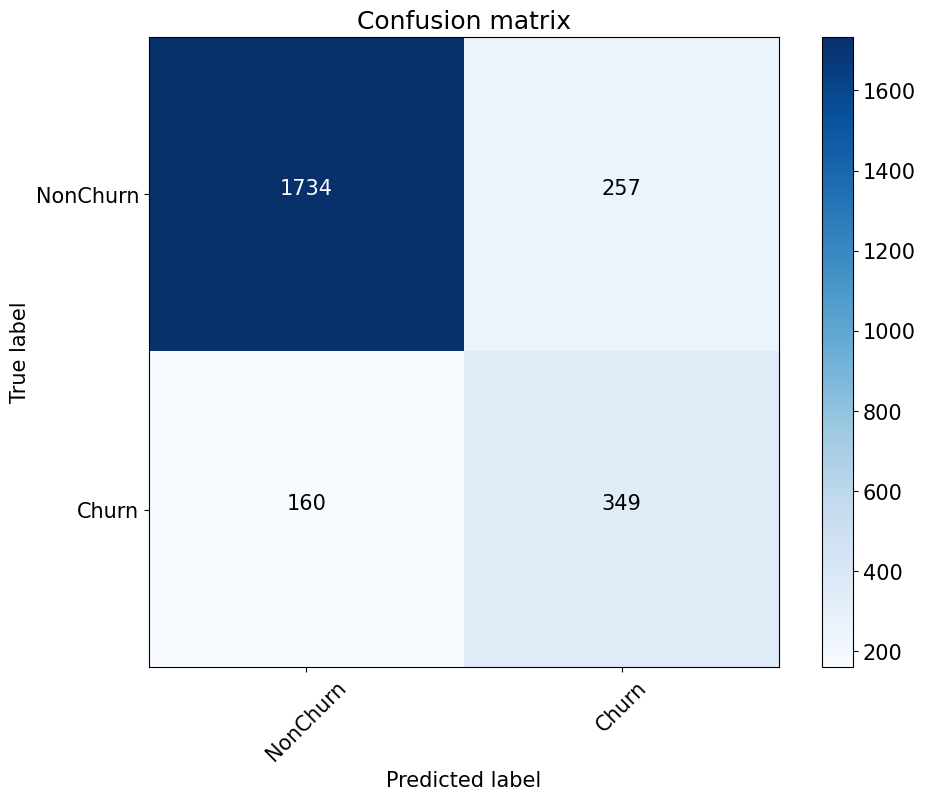

In [22]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_xgb>thresholds[ix_xgb])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [23]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]

retain_sum = (FP + TP) 
income = TP * 2

income - retain_sum


92

In [24]:
retain_sum

606

Из полученных результатов мы видим, что используя эту модель мы окупаем вложения равные 606 у.е. и имеем сверху чистой прибыли 92 у.е., что составляет примерно 16 %, что довольно неплохо.